In [82]:
import torch
from torch import nn


class Tokenizer:
    def __init__(self, vocabulary: str, special_tokens: list):
        self.special_tokens = special_tokens
        self.vocabulary_dictionary = {}
        self.reverse_vocabulary_dictionary = {}
        vocabulary_list = list(set(vocabulary))
        vocabulary_list = vocabulary_list + special_tokens
        for index, token in enumerate(vocabulary_list):
            self.vocabulary_dictionary[token] = index
            self.reverse_vocabulary_dictionary[index] = token

    def tokenize(self, text: str, pad_before: list = None, pad_after: list = None) -> torch.Tensor:
        split_string = list(text)
        pad_before = [] if pad_before is None else pad_before
        pad_after = [] if pad_after is None else pad_after
        full = pad_before + split_string + pad_after
        out = torch.Tensor([self.vocabulary_dictionary[letter] for letter in full])
        out = out.long()
        return out

    def untokenize(self, tensor: torch.Tensor) -> list:
        out_list = [self.reverse_vocabulary_dictionary[token.item()] for token in tensor]
        return out_list

In [83]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, latent_size: int, vocabulary_size: int, num_attention_heads: int, encode_depth: int) -> None:
        super().__init__()

        self.latent_size = latent_size
        self.vocabulary_size = vocabulary_size
        self.encode_depth = encode_depth

        self.lrelu = nn.LeakyReLU()

        self.latent_space = torch.zeros(latent_size).to("cuda")

        self.embedding = nn.Embedding(vocabulary_size, latent_size)

        self.encoder_mha = nn.MultiheadAttention(embed_dim=latent_size, num_heads=num_attention_heads, batch_first=True)
        self.encoder_projection = nn.Linear(latent_size, latent_size)
        self.encoder_mlp = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            self.lrelu,
            nn.Linear(latent_size * 4, latent_size),
        )
        self.encoder_mha_blocks = nn.ModuleList([self.encoder_mha for _ in range(encode_depth)])
        self.encoder_projection_layers = nn.ModuleList([self.encoder_projection for _ in range(encode_depth)])
        self.encoder_mlp_layers = nn.ModuleList([self.encoder_mlp for _ in range(encode_depth)])
        self.normalize_encoder_latent = nn.LayerNorm(latent_size)

        self.normalize_latent = nn.LayerNorm(latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=latent_size),
            self.lrelu,
            nn.Linear(in_features=latent_size, out_features=self.vocabulary_size),
        )

    def zero_latent_space(self):
        self.latent_space.zero_()

    def encode_sequence(self, latent_space: torch.Tensor, sequence: torch.Tensor) -> torch.Tensor:
        """ in size [seq_len], out size [self.latent_size] """
        tokens = self.embedding(sequence)
        seq_len = tokens.size(0)

        for index in range(seq_len):
            curr_tok = tokens[index]
            # latent_copy = self.latent_space
            temp_seq = torch.stack([curr_tok, latent_space]).to("cuda")
            for i in range(self.encode_depth):
                attended_seq, _ = self.encoder_mha_blocks[i](temp_seq, temp_seq, temp_seq)
                attended_seq = self.encoder_projection_layers[i](attended_seq)
                attended_seq = self.encoder_mlp_layers[i](attended_seq)
                temp_seq = temp_seq + attended_seq
                temp_seq = self.normalize_encoder_latent(temp_seq)
            latent_space = temp_seq[1]
        return latent_space

    def decode_latent(self, latent_space) -> torch.Tensor:
        out = self.decoder(latent_space)
        return out

    def inference(self, latent_space: torch.Tensor, in_sequence: torch.Tensor, max_len, end_at: str) -> torch.Tensor:
        out_sequence = []
        self.latent_space = torch.zeros(self.latent_size).to("cuda")
        lat_space = self.encode_sequence(latent_space=self.latent_space, sequence=in_sequence)
        while len(out_sequence) < max_len:
            predictions = self.decode_latent(latent_space=lat_space)
            prediction = torch.argmax(predictions)
            out_sequence.append(tokenizer.reverse_vocabulary_dictionary[prediction.item()])
            print(out_sequence[-1], end="")
            if out_sequence[-1] == end_at:
                break
            lat_space = self.encode_sequence(latent_space=lat_space, sequence=prediction.unsqueeze(0))
        return out_sequence

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        latent = torch.zeros(self.latent_size).to("cuda")
        latent = self.encode_sequence(latent, tokens)
        output = self.decode_latent(latent)
        return output

In [84]:
import torch

vocab = "abcdefghijklmnopqrstuvwxyz .,<>/?[]{}-_=+1234567890!@#$%^&*()`~ABCDEFGHIJKLMNOPQRSTUVWXYZ\|"
spec_tok = ["<model>", "</model>", "<user>", "</user>", "<system>", "</system>", "<unknown>", "<padding>",
            "<temp1>", "<temp2>", "<temp3>", "<temp4>", "<temp5>", "<temp6>", "<temp7>", "<temp8>", "<temp9>"]
tokenizer = Tokenizer(vocabulary=vocab, special_tokens=spec_tok)
foo = tokenizer.tokenize(text="hello world", pad_before=["<model>"], pad_after=["</model>"])
print(foo)
unfoo = tokenizer.untokenize(foo)
print(unfoo)
model = Model(latent_size=1024, vocabulary_size=len(tokenizer.vocabulary_dictionary), num_attention_heads=4,
              encode_depth=5).to("cuda")

tensor([91, 65, 80, 57, 57, 53, 18, 68, 53, 59, 57, 88, 92])
['<model>', 'h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '</model>']


In [85]:
texts = [
    "The fat cat took a nap.",
    "We go to school every day.",
    "The moon shines at night.",
    "I write letters to my friend.",
    "She feeds the hungry cat.",
]

training_texts = []
for text in texts:
    tensor_text = tokenizer.tokenize(text=text, pad_before=["<model>"], pad_after=["</model>"])
    training_texts.append(tensor_text.to("cuda"))

In [86]:
import torch
import random

EPOCHS = 1
# BATCH_SIZE = 3
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

model.train()
optimizer.zero_grad()

loss_hist = []

loss_avg = 0

for epoch in range(EPOCHS):
    random.shuffle(training_texts)
    for text in training_texts:
        for index, letter in enumerate(text):
            if 0 < index:
                # rand_index = random.randint(1, len(text) - 1)
                train_text = text[:index]
                label_text = letter
                raw_logits = model(train_text)
                loss = loss_fn(raw_logits, label_text)
                loss.backward()
                loss_avg += loss.item()

        loss_avg /= len(text)
        loss_hist.append(loss_avg)
        print(f"E {epoch + 1:,}/{EPOCHS:,} - {((epoch + 1) / EPOCHS) * 100:.2f}% | Loss: {loss_avg:.5f}")
        loss_avg = 0
        optimizer.step()
        optimizer.zero_grad()

E 1/1 - 100.00% | Loss: 4.40361
E 1/1 - 100.00% | Loss: 3.87540
E 1/1 - 100.00% | Loss: 3.52349
E 1/1 - 100.00% | Loss: 3.71474
E 1/1 - 100.00% | Loss: 3.51119


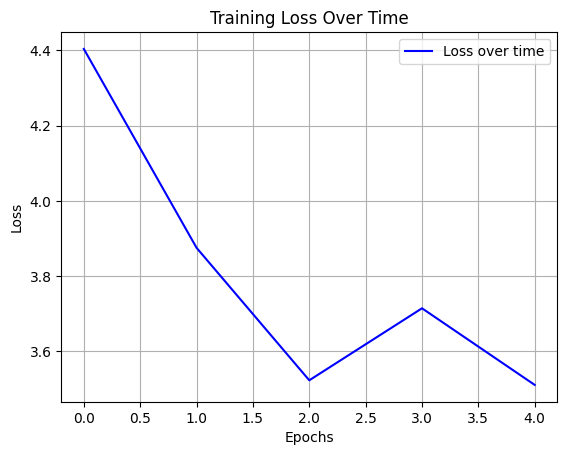

In [87]:
import matplotlib.pyplot as plt

plt.plot(loss_hist, label="Loss over time", color="blue")  # Line plot
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [88]:
import torch

txt = "She feeds the hungry cat."
foo = tokenizer.tokenize(text=txt, pad_before=["<model>"])
foo = foo.to("cuda")
out_seq = model.inference(latent_space=model.latent_space, in_sequence=foo, max_len=100, end_at="</model>")
print(out_seq)

                                                                                                    [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
